In [38]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from LDGD.model import ARDRBFKernel, LDGD
from LDGD.model.experimental.GP_scratch import bGPLVM
from LDGD.visualization import plot_box_plots
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.mlls import VariationalELBO
import gpytorch
import numpy as np
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import json
import winsound

from LDGD.visualization.vizualize_utils import plot_heatmap, plot_2d_scatter, plot_ARD_gplvm
from LDGD.visualization.vizualize_utils import plot_loss_gplvm, plot_scatter_gplvm, plot_box_plots

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
np.random.seed(42)
torch.manual_seed(42)

duration = 1000  # milliseconds
freq = 440  # Hz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
def train_model(data_cont, data_cat, settings, filename):
    num_points, data_dim = data_cont.shape
    batch_shape = torch.Size([data_dim])
    settings['use_gpytorch'] = True
    if settings['use_gpytorch'] is False:
        kernel_cls = ARDRBFKernel(input_dim=settings['latent_dim'])
        kernel_reg = ARDRBFKernel(input_dim=settings['latent_dim'])
    else:
        kernel_reg = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=settings['latent_dim']))
        kernel_cls = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=settings['latent_dim']))

    likelihood_reg = GaussianLikelihood(batch_shape=batch_shape)
    likelihood_cls = BernoulliLikelihood()


    if settings['load_model'] is True:
        with open(f'./saved_models/fig3_ldgd_{filename}_settings.json', 'r') as file:
            settings = json.load(file)
        model = LDGD(data_cont,
                kernel_reg=kernel_reg,
                kernel_cls=kernel_cls,
                num_classes=data_cat.shape[-1],
                num_inducing_points_cls=settings['num_inducing_points_cls'],
                num_inducing_points_reg=settings['num_inducing_points_reg'],
                latent_dim=settings['latent_dim'],
                likelihood_reg=likelihood_reg,
                likelihood_cls=likelihood_cls,
                use_gpytorch=settings['use_gpytorch'],
                shared_inducing_points=settings['shared_inducing_points'],
                x_init=settings['x_init'])
        model.load_weights(path_save='./saved_models/', file_name=f"fig3_ldgd_{filename}.pth")
        history_train = model.history_train
        losses = model.history_train['elbo_loss']
    else:
        model = LDGD(data_cont,
                kernel_reg=kernel_reg,
                kernel_cls=kernel_cls,
                num_classes=data_cat.shape[-1],
                num_inducing_points_cls=settings['num_inducing_points_cls'],
                num_inducing_points_reg=settings['num_inducing_points_reg'],
                latent_dim=settings['latent_dim'],
                likelihood_reg=likelihood_reg,
                likelihood_cls=likelihood_cls,
                use_gpytorch=settings['use_gpytorch'],
                shared_inducing_points=settings['shared_inducing_points'],
                x_init=settings['x_init'])

        losses, history_train = model.train_model(yn=data_cont,
                                                  ys=data_cat,
                                                  epochs=settings['num_epochs_train'],
                                                  batch_size=settings['batch_size'])

        if settings['save_model'] is True:
            model.save_wights(path_save='./saved_models/', file_name=f"fig3_ldgd_{filename}")
        with open(f'./saved_models/fig3_ldgd_{filename}_settings.json', 'w') as f:
            json.dump(settings, f)
    return model, losses, history_train, model_settings


# Load MNIST dataset

In [47]:
def create_dataset(random_state, test_size, dataset='mnist', **kwargs):
    if dataset == 'mnist':
        mnist_train = MNIST(root='./data', train=True, download=True, transform=ToTensor())
        mnist_test = MNIST(root='./data', train=False, download=True, transform=ToTensor())

        # Flatten the images and convert labels
        x_train = mnist_train.data.view(mnist_train.data.size(0), -1).numpy()
        x_train = x_train/x_train.max()
        y_train = mnist_train.targets.numpy()

        # Concatenate train and test sets to split them later
        x_test = mnist_test.data.view(mnist_test.data.size(0), -1).numpy()
        x_test = x_test/x_test.max()
        y_test = mnist_test.targets.numpy()

        # One-hot encode the labels
        y_one_hot_train = np.zeros((y_train.shape[0], len(np.unique(y_train))))
        y_one_hot_train[np.arange(y_train.shape[0]), y_train] = 1

        y_one_hot_test = np.zeros((y_test.shape[0], len(np.unique(y_test))))
        y_one_hot_test[np.arange(y_test.shape[0]), y_test] = 1

        orig_data = None  # No original data in the case of MNIST


    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_one_hot_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_one_hot_test, dtype=torch.float32)
    y_train_labels_tensor = torch.tensor(y_train)
    y_test_labels_tensor = torch.tensor(y_test)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, y_train_labels_tensor, y_test_labels_tensor, orig_data

# Load Oil dataset

In [4]:
train_data_oil = np.load('../data/train_data.npy', allow_pickle=True)
test_data_oil = np.load('../data/test_data.npy', allow_pickle=True)

yn_train_oil, ys_train_oil, labels_train_oil = train_data_oil.take(0)['yn_train'], train_data_oil.take(0)['ys_train'], train_data_oil.take(0)['labels_train']
yn_test_oil, ys_test_oil, labels_test_oil = test_data_oil.take(0)['yn_test'], test_data_oil.take(0)['ys_test'], test_data_oil.take(0)['labels_test']

yn_train_oil, ys_train_oil, labels_train_oil = torch.Tensor(yn_train_oil), torch.Tensor(ys_train_oil), torch.Tensor(labels_train_oil)
yn_test_oil, ys_test_oil, labels_test_oil = torch.Tensor(yn_test_oil), torch.Tensor(ys_test_oil), torch.Tensor(labels_test_oil)

print(f"Train size : {yn_train_oil.shape[0]} Test size : {yn_test_oil.shape[0]}")

Train size : 800 Test size : 200


# Load IRIS dataset

In [5]:
train_data_iris = np.load('../data/train_data_iris.npy', allow_pickle=True)
test_data_iris = np.load('../data/test_data_iris.npy', allow_pickle=True)

yn_train_iris, ys_train_iris, labels_train_iris = train_data_iris.take(0)['yn_train'], train_data_iris.take(0)['ys_train'], train_data_iris.take(0)['labels_train']
yn_test_iris, ys_test_iris, labels_test_iris = test_data_iris.take(0)['yn_test'], test_data_iris.take(0)['ys_test'], test_data_iris.take(0)['labels_test']

yn_train_iris, ys_train_iris, labels_train_iris = torch.Tensor(yn_train_iris), torch.Tensor(ys_train_iris), torch.Tensor(labels_train_iris)
yn_test_iris, ys_test_iris, labels_test_iris = torch.Tensor(yn_test_iris), torch.Tensor(ys_test_iris), torch.Tensor(labels_test_iris)

print(f"Train size : {yn_train_iris.shape[0]} Test size : {yn_test_iris.shape[0]}")


Train size : 120 Test size : 30


# Task 4: Reconstruction

In [22]:
model_settings = {
    'latent_dim': 2,
    'num_inducing_points_reg': 30,
    'num_inducing_points_cls': 30,
    'num_epochs_train': 5000,
    'num_epochs_test': 5000,
    'batch_size': 100,
    'load_trained_model': False,
    'load_tested_model': False,
    'use_gpytorch': True,
    'n_features': 10,
    'save_model': True,
    'load_model':True,
    'x_init': 'pca',
    'shared_inducing_points': False
}

In [23]:
model_oil, losses_oil, history_train_oil, model_settings = train_model(data_cont = yn_train_oil,
                                                                       data_cat = ys_train_oil,
                                                                       settings = model_settings,
                                                                       filename = 'oil_2d')
winsound.Beep(freq, duration*3)

In [24]:
predictions_oil, metrics_oil, history_test = model_oil.evaluate(yn_test=yn_test_oil, ys_test=labels_test_oil, epochs=5000)

alpha_reg_oil = 1 / model_oil.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls_oil = 1 / model_oil.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x_oil = model_oil.x.q_mu.cpu().detach().numpy()
std_oil = torch.nn.functional.softplus(model_oil.x.q_log_sigma).cpu().detach().numpy()

x_test_oil = model_oil.x_test.q_mu.cpu().detach().numpy()
std_test_oil = torch.nn.functional.softplus(model_oil.x_test.q_log_sigma).cpu().detach().numpy()
winsound.Beep(freq, duration)

Epoch 1/5000, Loss: 728.7002563476562
Epoch 11/5000, Loss: 732.5457763671875
Epoch 21/5000, Loss: 678.929443359375
Epoch 31/5000, Loss: 620.172607421875
Epoch 41/5000, Loss: 725.342529296875
Epoch 51/5000, Loss: 676.8485717773438
Epoch 61/5000, Loss: 567.3170166015625
Epoch 71/5000, Loss: 624.35791015625
Epoch 81/5000, Loss: 582.3927612304688
Epoch 91/5000, Loss: 543.4263916015625
Epoch 101/5000, Loss: 499.021240234375
Epoch 111/5000, Loss: 546.8909912109375
Epoch 121/5000, Loss: 451.2595520019531
Epoch 131/5000, Loss: 528.5084228515625
Epoch 141/5000, Loss: 507.20440673828125
Epoch 151/5000, Loss: 452.78704833984375
Epoch 161/5000, Loss: 423.95184326171875
Epoch 171/5000, Loss: 430.03387451171875
Epoch 181/5000, Loss: 449.5674743652344
Epoch 191/5000, Loss: 390.8255615234375
Epoch 201/5000, Loss: 433.62921142578125
Epoch 211/5000, Loss: 378.3196716308594
Epoch 221/5000, Loss: 376.931884765625
Epoch 231/5000, Loss: 358.3106384277344
Epoch 241/5000, Loss: 357.3930358886719
Epoch 251/500

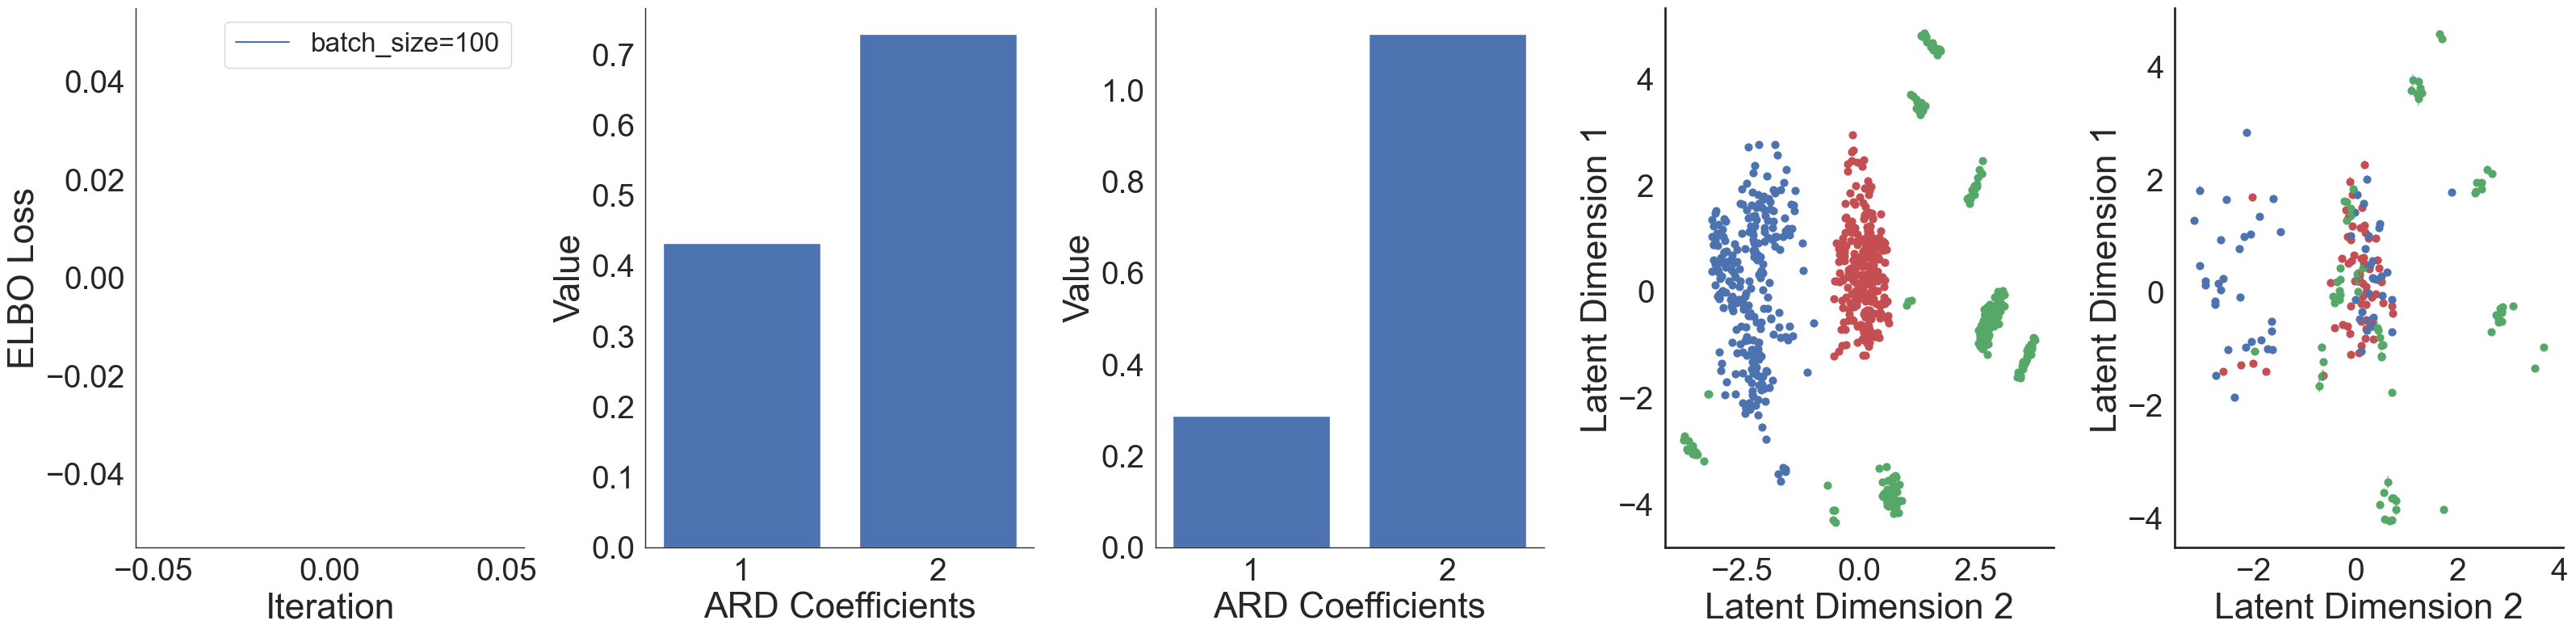

In [25]:
latent_dim = x_oil.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls_oil), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

fig, axs = plt.subplots(1,5, figsize=(32, 8))


plot_loss_gplvm(losses_oil, ax=axs[0])
plot_ARD_gplvm(latent_dim, alpha_cls_oil, ax=axs[2])
plot_ARD_gplvm(latent_dim, alpha_reg_oil, ax=axs[1])
plot_scatter_gplvm(x_oil, labels_train_oil, l1=l1, l2=l2, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=std_oil)
plot_scatter_gplvm(x_test_oil, labels_test_oil, l1=l1, l2=l2, ax=axs[4], colors=['r', 'b', 'g'], show_errorbars=True, std=std_test_oil)
plt.tight_layout()


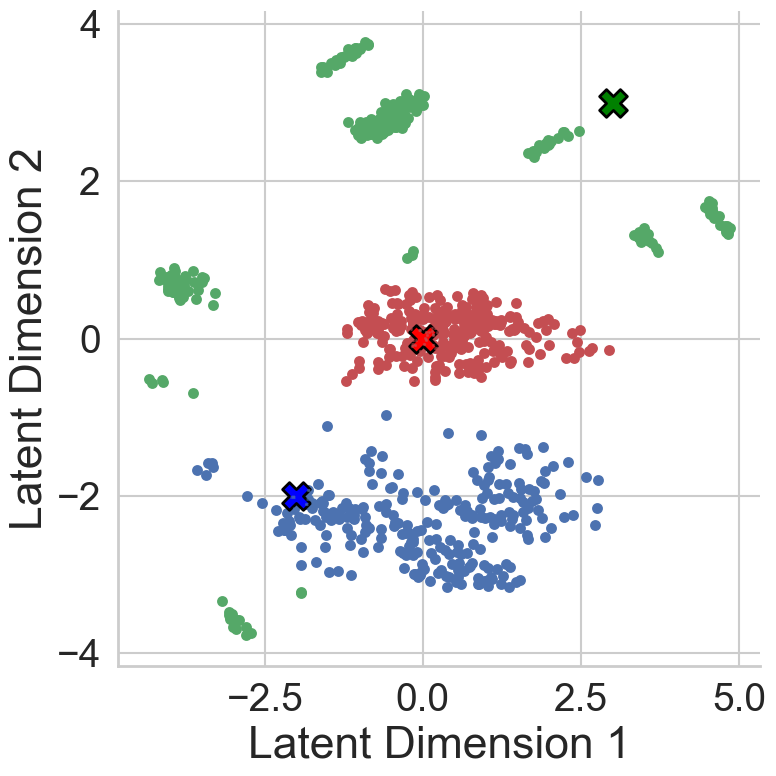

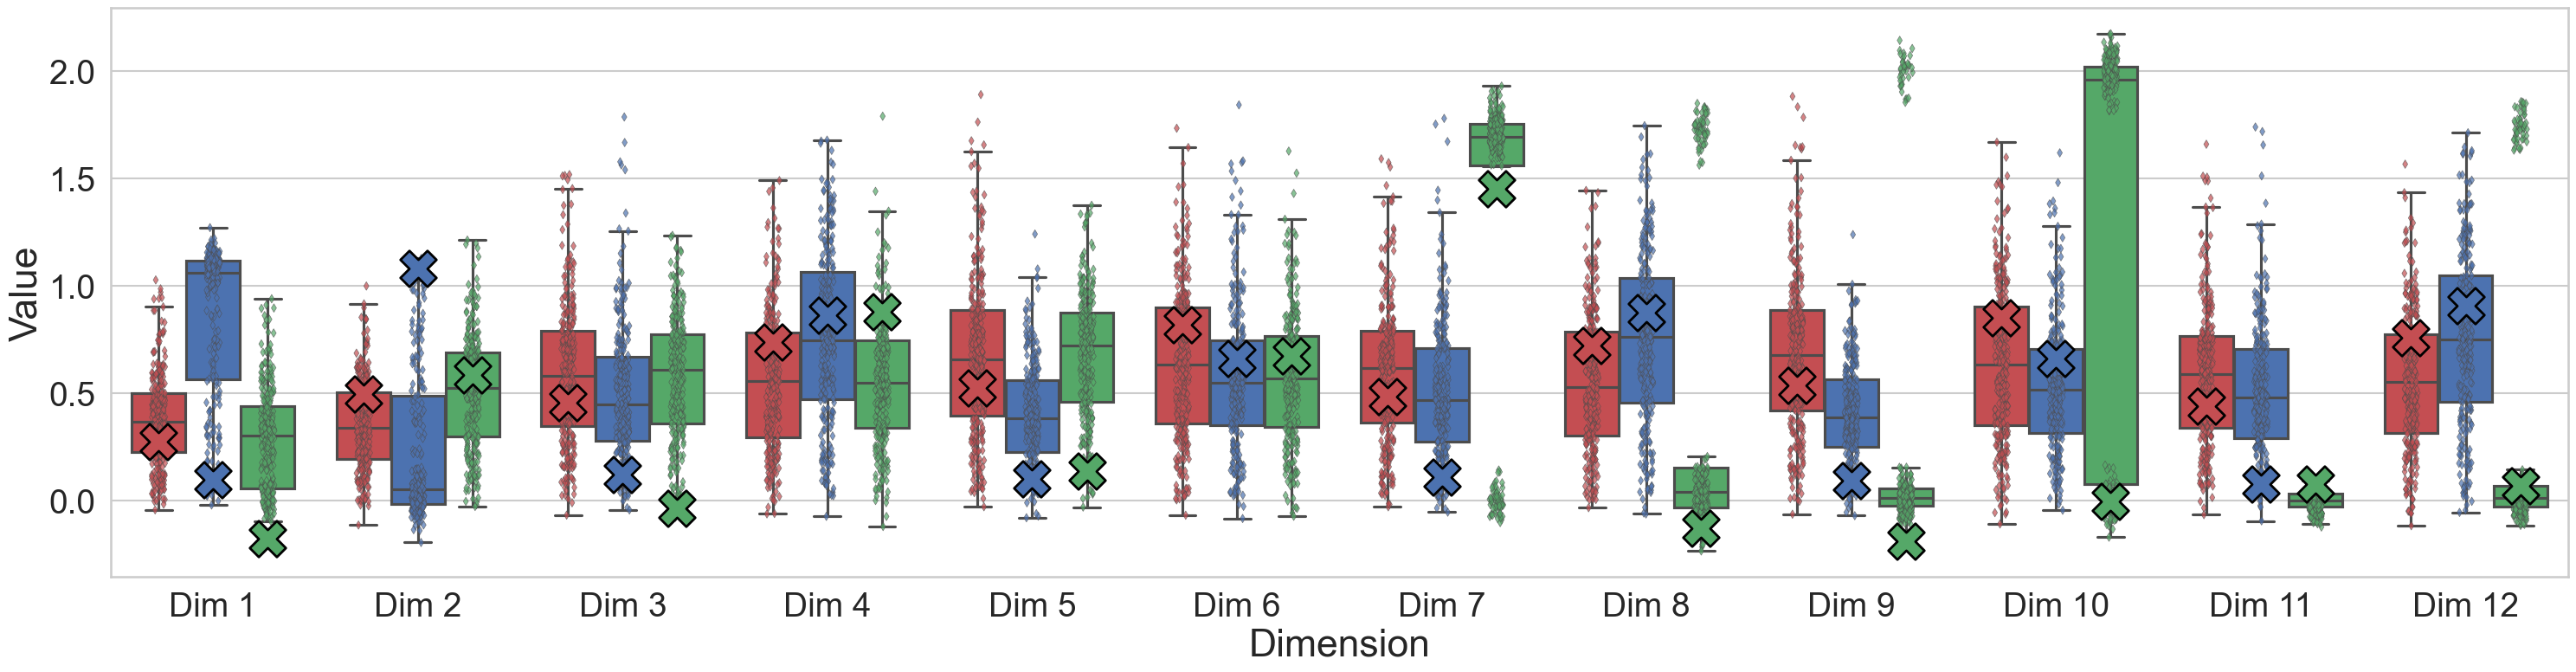

In [37]:
fig, ax = plt.subplots(1, figsize=(8, 8))
test_point = torch.tensor([[3,3], [0, 0], [-2,-2]])

test_point_reconstructed, predictions_std = model_oil.regress_x(test_point)
plot_scatter_gplvm(x_oil, labels_train_oil, l1=l1, l2=l2, ax=ax, colors=['r', 'b', 'g'], show_errorbars=True, std=std_oil)
ax.scatter(test_point[0,0], test_point[0,1], marker='X', color='green', s=400, alpha=1, edgecolor='black', linewidth=2)
ax.scatter(test_point[1,0], test_point[1,1], marker='X', color='red', s=400, alpha=1, edgecolor='black', linewidth=2)
ax.scatter(test_point[2,0], test_point[2,1], marker='X', color='blue', s=400, alpha=1, edgecolor='black', linewidth=2)
plt.tight_layout()
plt.savefig("./saved_results/figure4_oil_latent_scatter_with_test_point.png", bbox_inches='tight')
plt.savefig("./saved_results/figure4_oil_latent_scatter_with_test_point.svg", bbox_inches='tight')

plot_box_plots(data=yn_train_oil, labels=labels_train_oil, save_path='saved_results/',
               file_name='box_plot_oil_with_point', new_point_values=test_point_reconstructed.cpu().detach(),
               new_point_label=[2, 0, 1], marker='X')

plt.tight_layout()
plt.savefig("./saved_results/figure4_oil_barplot_with_test_point.png")
plt.savefig("./saved_results/figure4_oil_barplot_with_test_point.svg")


In [27]:
model_iris, losses_iris, history_train_iris, model_settings = train_model(data_cont = yn_train_iris,
                                                                       data_cat = ys_train_iris,
                                                                       settings = model_settings,
                                                                       filename = 'iris_2d')
winsound.Beep(freq, duration*3)

In [28]:
predictions_iris, metrics_iris, history_test = model_iris.evaluate(yn_test=yn_test_iris, ys_test=labels_test_iris, epochs=2000)

alpha_reg_iris = 1 / model_iris.kernel_reg.base_kernel.lengthscale.cpu().detach().numpy()
alpha_cls_iris = 1 / model_iris.kernel_cls.base_kernel.lengthscale.cpu().detach().numpy()

x_iris = model_iris.x.q_mu.cpu().detach().numpy()
std_iris = torch.nn.functional.softplus(model_iris.x.q_log_sigma).cpu().detach().numpy()

x_test_iris = model_iris.x_test.q_mu.cpu().detach().numpy()
std_test_iris = torch.nn.functional.softplus(model_iris.x_test.q_log_sigma).cpu().detach().numpy()
winsound.Beep(freq, duration)

Epoch 1/2000, Loss: 1620.5067138671875
Epoch 11/2000, Loss: 1318.3427734375
Epoch 21/2000, Loss: 1264.2613525390625
Epoch 31/2000, Loss: 1568.8458251953125
Epoch 41/2000, Loss: 1634.9517822265625
Epoch 51/2000, Loss: 1041.0628662109375
Epoch 61/2000, Loss: 1194.3262939453125
Epoch 71/2000, Loss: 1008.3282470703125
Epoch 81/2000, Loss: 699.4188232421875
Epoch 91/2000, Loss: 843.8967895507812
Epoch 101/2000, Loss: 921.3947143554688
Epoch 111/2000, Loss: 788.4013061523438
Epoch 121/2000, Loss: 455.12603759765625
Epoch 131/2000, Loss: 677.8797607421875
Epoch 141/2000, Loss: 651.2725219726562
Epoch 151/2000, Loss: 340.8602600097656
Epoch 161/2000, Loss: 430.8977355957031
Epoch 171/2000, Loss: 549.3667602539062
Epoch 181/2000, Loss: 369.7811584472656
Epoch 191/2000, Loss: 409.20172119140625
Epoch 201/2000, Loss: 422.904296875
Epoch 211/2000, Loss: 327.69183349609375
Epoch 221/2000, Loss: 315.3384704589844
Epoch 231/2000, Loss: 258.51812744140625
Epoch 241/2000, Loss: 209.7716827392578
Epoch 

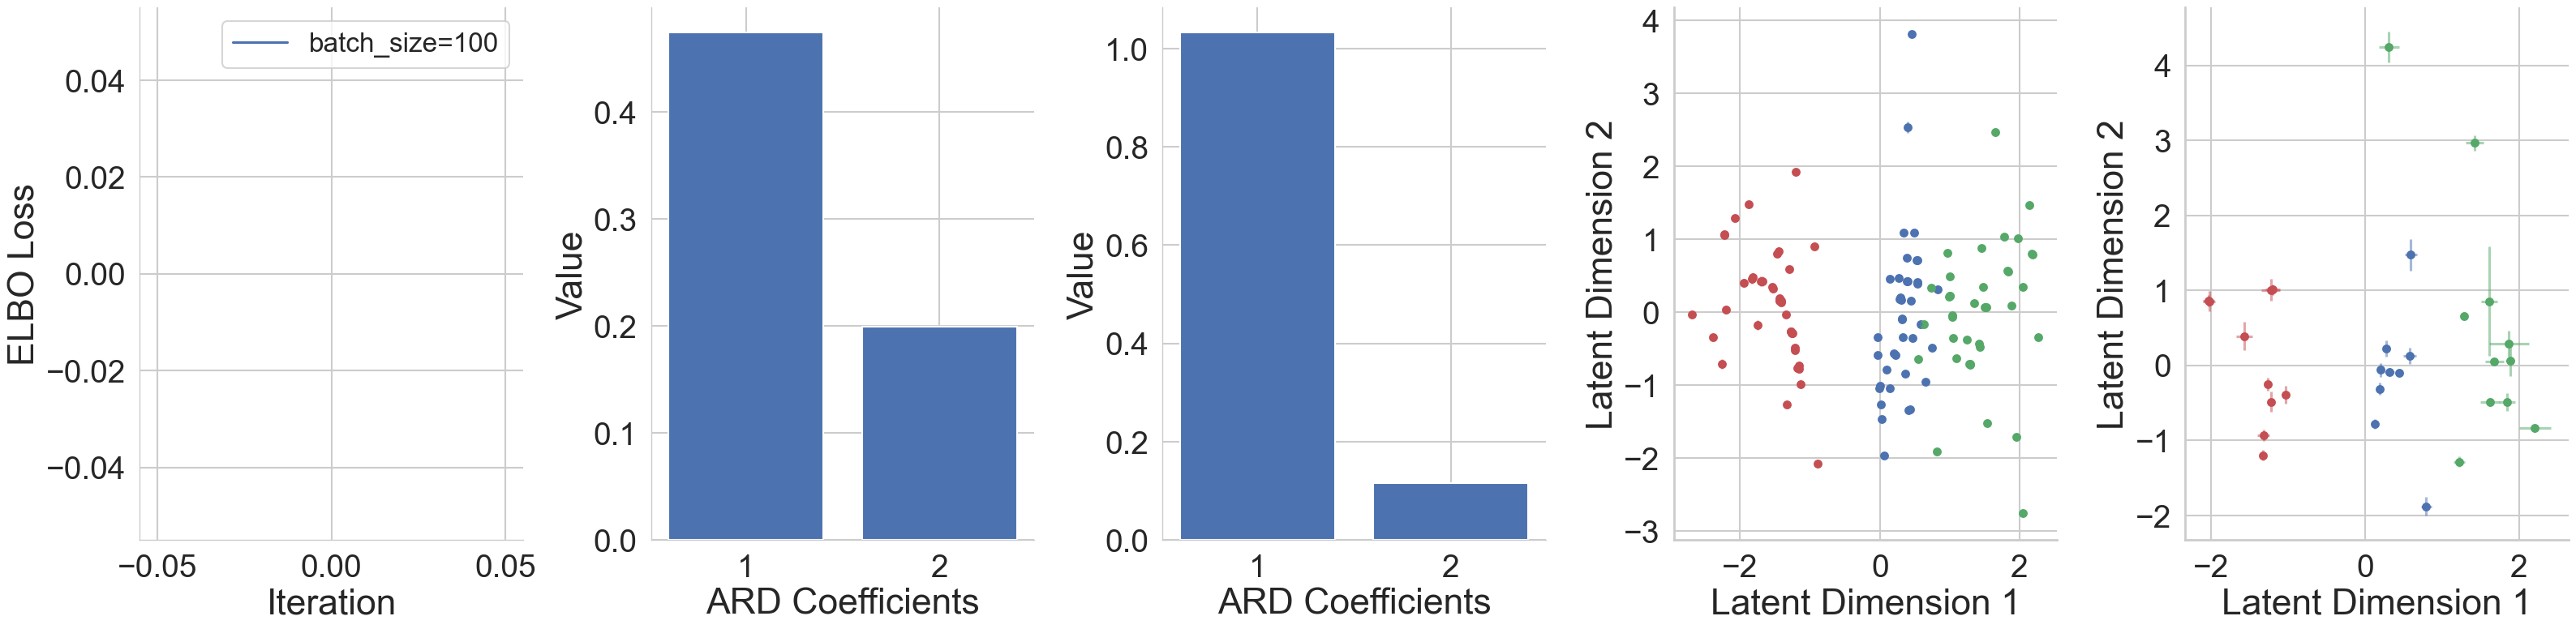

In [29]:
latent_dim = x_iris.shape[-1]
values, indices = torch.topk(torch.tensor(alpha_cls_iris), k=2, largest=True)
l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

fig, axs = plt.subplots(1,5, figsize=(32, 8))


plot_loss_gplvm(losses_iris, ax=axs[0])
plot_ARD_gplvm(latent_dim, alpha_cls_iris, ax=axs[2])
plot_ARD_gplvm(latent_dim, alpha_reg_iris, ax=axs[1])
plot_scatter_gplvm(x_iris, labels_train_iris, l1=l1, l2=l2, ax=axs[3], colors=['r', 'b', 'g'], show_errorbars=True, std=std_iris)
plot_scatter_gplvm(x_test_iris, labels_test_iris, l1=l1, l2=l2, ax=axs[4], colors=['r', 'b', 'g'], show_errorbars=True, std=std_test_iris)
plt.tight_layout()


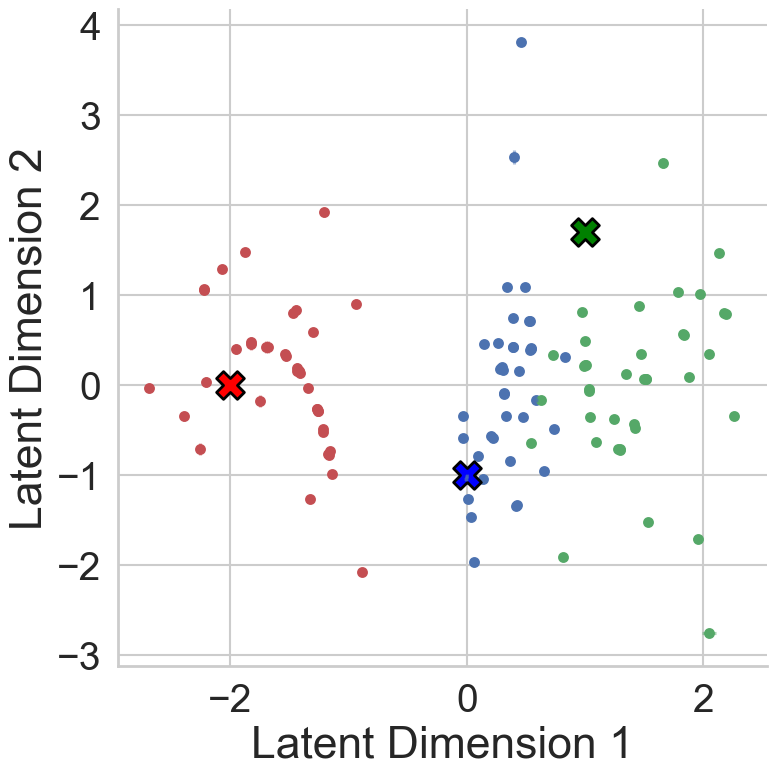

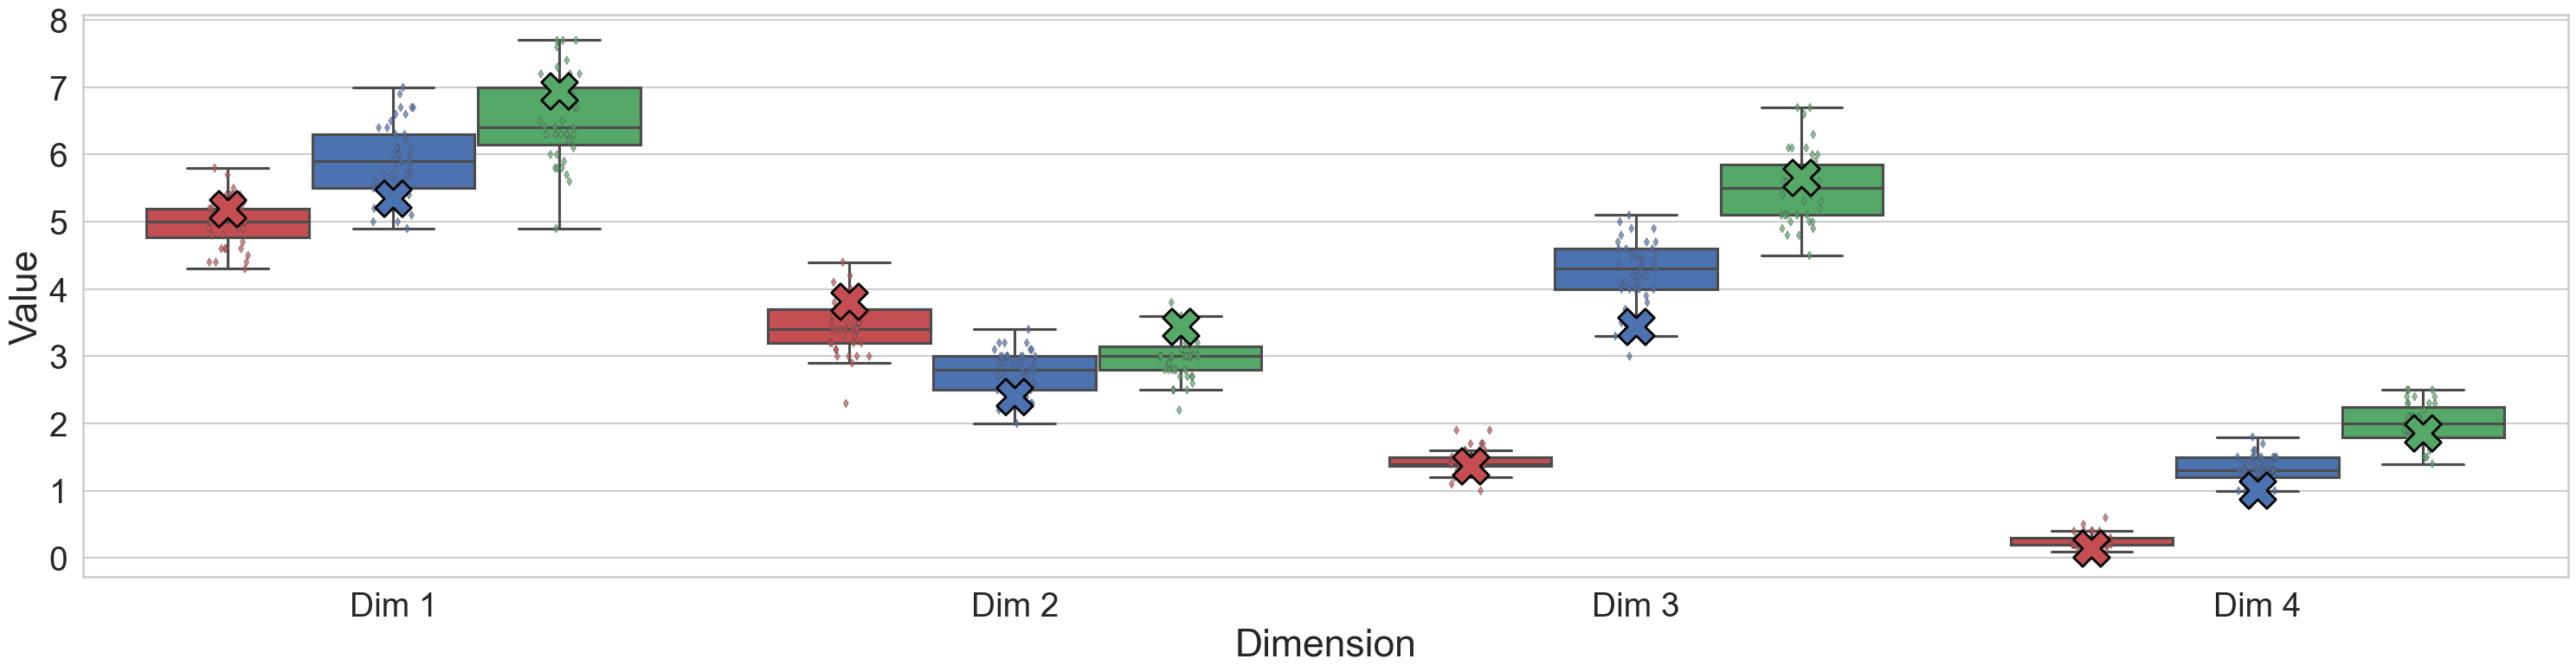

In [36]:
fig, ax = plt.subplots(1, figsize=(8, 8))
test_point = torch.tensor([[1,1.7], [-2, 0], [0,-1]])

test_point_reconstructed, predictions_std = model_iris.regress_x(test_point)
plot_scatter_gplvm(x_iris, labels_train_iris, l1=l1, l2=l2, ax=ax, colors=['r', 'b', 'g'], show_errorbars=True, std=std_iris)
ax.scatter(test_point[0,0], test_point[0,1], marker='X', color='green', s=400, alpha=1, edgecolor='black', linewidth=2)
ax.scatter(test_point[1,0], test_point[1,1], marker='X', color='red', s=400, alpha=1, edgecolor='black', linewidth=2)
ax.scatter(test_point[2,0], test_point[2,1], marker='X', color='blue', s=400, alpha=1, edgecolor='black', linewidth=2)
plt.grid('off')
plt.tight_layout()
plt.savefig("./saved_results/fig4_iris_latent_scatter_with_test_point.png", bbox_inches='tight')
plt.savefig("./saved_results/fig4_iris_latent_scatter_with_test_point.svg", bbox_inches='tight')

plot_box_plots(data=yn_train_iris, labels=labels_train_iris, save_path='saved_results/', file_name='box_plot_iris_with_point', new_point_values=test_point_reconstructed.cpu().detach(), new_point_label=[2, 0, 1], marker='X')

plt.tight_layout()
plt.savefig("./saved_results/fig4_iris_barplot_with_test_point.png")
plt.savefig("./saved_results/fig4_iris_barplot_with_test_point.svg")


# MNIST

In [45]:
model_settings = {
    'latent_dim': 10,
    'num_inducing_points_reg': 150,
    'num_inducing_points_cls': 150,
    'num_epochs_train': 20000,
    'num_epochs_test': 20000,
    'batch_size': 700,
    'load_trained_model': False,
    'load_tested_model': False,
    'shared_inducing_points': False,
    'use_gpytorch': True,
    'random_state': 65,
    'test_size': 0.2,
    'cls_weight': 1.0,
    'reg_weight': 1.0,
    'num_samples': 500,

}
np.random.seed(model_settings['random_state'])

In [48]:
# load raw data
yn_train, yn_test, ys_train, ys_test, labels_train, labels_test, _ = create_dataset(random_state=model_settings['random_state'], test_size=0.2, dataset='mnist')
yn_train = yn_train/yn_train.max()
yn_test = yn_test/yn_test.max()

In [49]:
load_saved_result = True
batch_shape = torch.Size([yn_train.shape[-1]])
metric_fastldgd_list = []
model_mnist, losses_mnist, history_train_mnist, model_settings = train_model(data_cont = yn_train_iris,
                                                                           data_cat = ys_train_iris,
                                                                           settings = model_settings,
                                                                           filename = 'mnist')
winsound.Beep(freq, duration*3)

KeyError: 'load_model'

In [ ]:
predictions, metrics, history_test = model.evaluate(yn_test=yn_test, ys_test=labels_test,
                                                    epochs=model_settings['num_epochs_test'])
winsound.Beep(freq, duration*3)